In [337]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib as mpl
# set figure size
mpl.rcParams['figure.figsize'] = (13,8)

import os
if not os.path.exists('fig'):
    os.makedirs('fig')

In [282]:
'''import data set'''

filename = 'data_set_170705.xlsx'
xls_file = pd.read_excel(filename, sheetname =['driver_trips',
                                               'rider_trips',
                                               'driver_data',
                                               'rider_data',
                                               'city_metrics'])

rider_trips = xls_file['rider_trips']
city_metrics = xls_file['city_metrics']
rider_trips.head()
print(rider_trips.shape)

(60000, 10)


In [283]:
'''add a "hour" column and a "month" column '''
rider_trips['hour'] = rider_trips.request_time.dt.hour
rider_trips['month'] = rider_trips.request_time.dt.month

In [304]:
'''clean NaN data'''
#filter nan
rider_trips_filtered = rider_trips.dropna(subset=['estimated_time_to_arrival','surge_multiplier','trip_status'], how='any')
print(rider_trips_filtered.shape)

(57499, 13)


In [285]:
''' overview of rider_trips'''

print('Dataset time zone: from', rider_trips_filtered.request_time.min(), ' to ', rider_trips_filtered.request_time.max())
print('Number of trips:', rider_trips_filtered.shape[0])

#basic statistics for "estimated time to arrival" and "surge multipliers"
print('\n basic statistics for "ETA" and "surge multiplier" for all trips:  \n')
print(rider_trips_filtered[['estimated_time_to_arrival', 'surge_multiplier']].describe())

# basic statistics for "estimated time to arrival" by trip_status
print('\n basic statistics of "ETA" by "trip status": \n')
print(rider_trips_filtered.groupby('trip_status').estimated_time_to_arrival.agg(['count','mean', 'std','min','max']).reset_index())


Dataset time zone: from 2012-04-09 00:00:00  to  2012-05-06 23:55:00
Number of trips: 57499

 basic statistics for "ETA" and "surge multiplier" for all trips:  

       estimated_time_to_arrival  surge_multiplier
count               57499.000000      57499.000000
mean                    3.270866          1.165773
std                     2.148822          0.341366
min                     0.016667          1.000000
25%                     1.733333          1.000000
50%                     2.833333          1.000000
75%                     4.333333          1.200000
max                    53.416667          4.800000

 basic statistics of "ETA" by "trip status": 

      trip_status  count      mean       std       min        max
0       completed  51929  3.134331  1.979836  0.016667  51.716667
1          failed     20  5.261667  2.387198  1.683333   9.683333
2  rider_canceled   5550  4.541195  3.056405  0.066667  53.416667



 basic statistics of"ETA" for the whole city's completed trips: 

   index  estimated_time_to_arrival
0  count               51929.000000
1   mean                   3.134331
2    std                   1.979836
3    min                   0.016667
4    25%                   1.700000
5    50%                   2.750000
6    75%                   4.166667
7    max                  51.716667

 basic statistics of"ETA" by starting regions "start_geo" for completed trips: 

       start_geo  count      mean       std       min        max
0     Allen Abby   9306  3.138932  1.989695  0.016667  16.950000
1     Blair Bend   3676  4.243925  2.481363  0.033333  51.716667
2  Chelsea Court  34829  3.010993  1.877033  0.016667  34.616667
3    Daisy Drive   4118  3.176595  1.990311  0.033333  34.150000


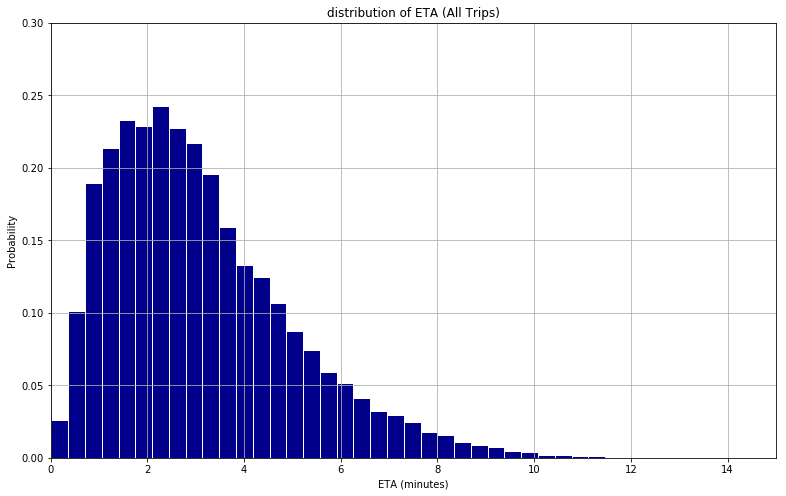

In [331]:
'''distribution of ETA for completed trips'''
trips_completed = rider_trips_filtered[rider_trips_filtered.trip_status == "completed"]
trips_completed.set_index('trip_status', inplace = True)
trips_completed.reset_index(inplace=True)

# basic statistics for "estimated time to arrival" for completed trips
print('\n basic statistics of"ETA" for the whole city\'s completed trips: \n')
print(trips_completed['estimated_time_to_arrival'].describe().reset_index())

# basic statistics for "estimated time to arrival" by regions
print('\n basic statistics of"ETA" by starting regions "start_geo" for completed trips: \n')
print(trips_completed.groupby('start_geo').estimated_time_to_arrival.agg(['count','mean', 'std','min','max']).reset_index())


#bins values
bin_numbers = 150
bin_values = np.linspace(trips_completed.estimated_time_to_arrival.min(), trips_completed.estimated_time_to_arrival.max(), bin_numbers)

# histogram of ETA for the whole city
ax = plt.figure()
ax = trips_completed.estimated_time_to_arrival.plot(kind='hist', normed=1, bins= bin_values, alpha = 1, color='darkblue', edgecolor='w')
ax.set_xlim(0, 15)
ax.set_ylim(0, 0.3)
plt.title('distribution of ETA (All Trips)')
plt.xlabel('ETA (minutes)')
plt.ylabel('Probability')
plt.grid()
plt.savefig('fig/distribution_ETA_all_trips.png')
plt.savefig('fig/distribution_ETA_all_trips.eps')
plt.show()


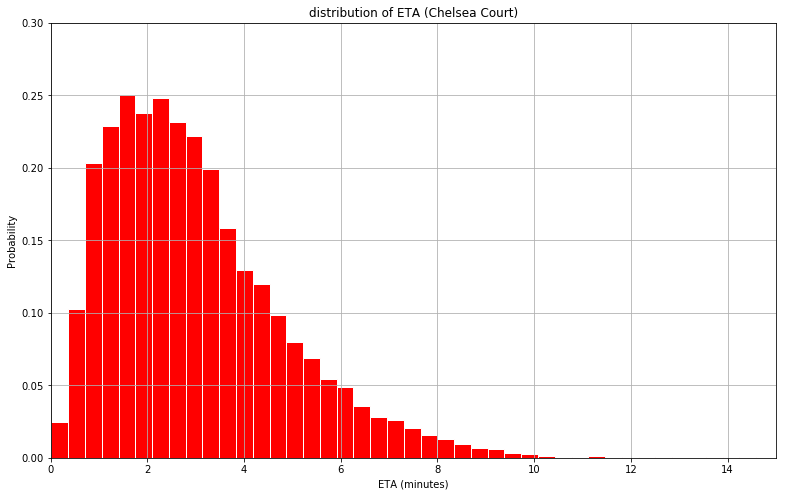

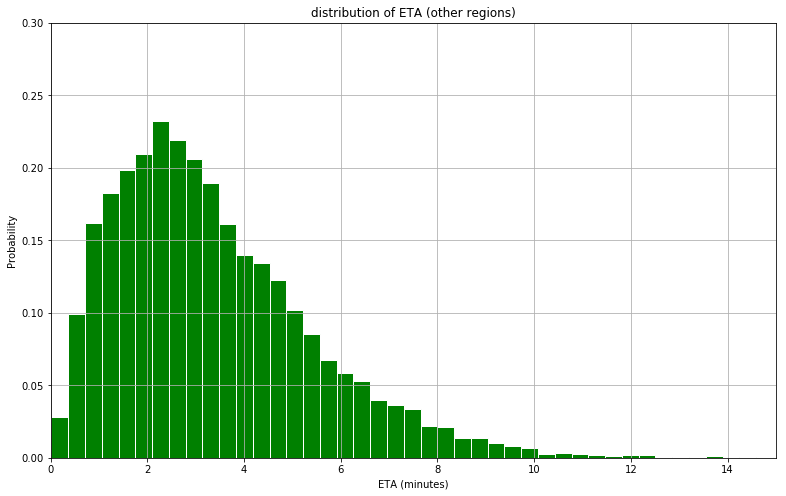

In [332]:
''' compare the distribution of ETA in Chelsea Court and other regions in the city'''

# histogram of ETA for trips starting at Chelsea Court
ax = plt.figure()
ax = trips_completed[trips_completed.start_geo=='Chelsea Court']\
                    .estimated_time_to_arrival.plot(kind='hist', normed=1, bins =bin_values, alpha = 1, color='red', edgecolor='w')
ax.set_xlim(0, 15)
ax.set_ylim(0, 0.3)
plt.title('distribution of ETA (Chelsea Court)')
plt.xlabel('ETA (minutes)')
plt.ylabel('Probability')
plt.grid()
plt.savefig('fig/distribution_ETA_CC.png')
plt.savefig('fig/distribution_ETA_CC.eps')
plt.show()


# histogram of ETA for trips starting from other regions than Chelsea Court
ax = plt.figure()
ax = trips_completed[trips_completed.start_geo != 'Chelsea Court']\
                    .estimated_time_to_arrival.plot(kind='hist', normed=1, bins =bin_values, alpha = 1, color='green', edgecolor='w')
ax.set_xlim(0, 15)
ax.set_ylim(0, 0.3)
plt.title('distribution of ETA (other regions)')
plt.xlabel('ETA (minutes)')
plt.ylabel('Probability')
plt.grid()
plt.savefig('fig/distribution_ETA_others.png')
plt.savefig('fig/distribution_ETA_others.eps')
plt.show()


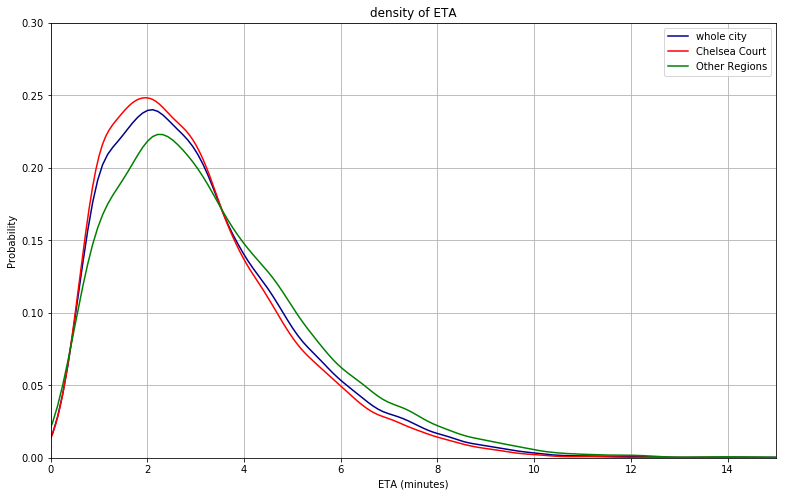

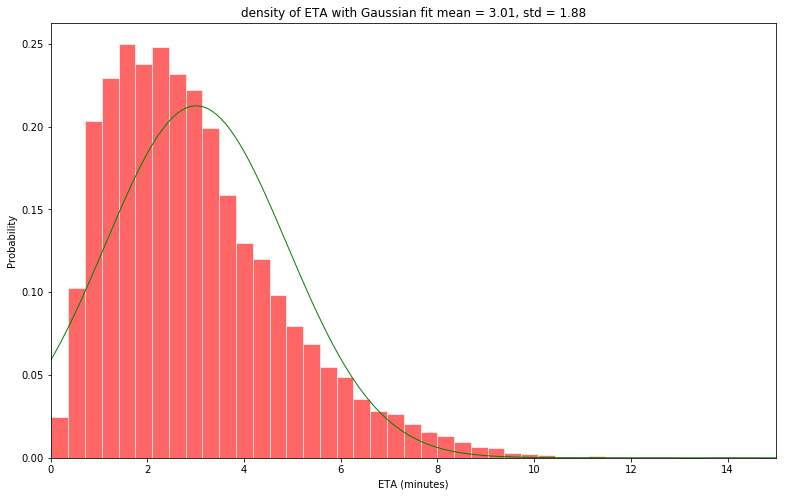

In [333]:
''' density of ETA and a calibration with Gaussian distribution'''

# density plot of ETA for trips
ax = plt.figure()
ax = trips_completed.estimated_time_to_arrival.plot(kind='kde', color ='darkblue', label = 'whole city')
ax = trips_completed[trips_completed.start_geo == 'Chelsea Court'].estimated_time_to_arrival.plot(kind = 'kde', color = 'red', label='Chelsea Court')
ax = trips_completed[trips_completed.start_geo != 'Chelsea Court'].estimated_time_to_arrival.plot(kind = 'kde', color = 'green', label='Other Regions')
lines, labels = ax.get_legend_handles_labels()
ax.set_xlim(0,15)
ax.set_ylim(0,0.3)
ax.legend(lines, labels, loc=1)
plt.title('density of ETA')
plt.xlabel('ETA (minutes)')
plt.ylabel('Probability')
plt.grid()
plt.savefig('fig/density_ETA_CC_city.png')
plt.savefig('fig/density_ETA_CC_city.eps')
plt.show()

# gaussian fit for ETA, trips in CC
data = trips_completed[trips_completed.start_geo == 'Chelsea Court'].estimated_time_to_arrival
mu, std = stats.norm.fit(data)

plt.figure()
plt.hist(data, normed=1, bins = bin_values, alpha = 0.6, color='red', edgecolor='w')
plt.xlim(0,15)
x = np.linspace(0, 15, bin_numbers)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, color='green', linewidth=1)
plt.title('density of ETA with Gaussian fit mean = {:.2f}, std = {:.2f}'.format(mu, std))
plt.xlabel('ETA (minutes)')
plt.ylabel('Probability')
plt.savefig('fig/density_ETA_CC_gaussian_fit.png')
plt.savefig('fig/density_ETA_CC_gaussian_fit.eps')
plt.show()


We can observe that for complete trips, the region Chelsea Court has the lowest mean ETA among all regions in the city X. Moreover, its distribution is skewed with respect to the Gaussian distribution fited with its mean and std.


 basic statistics of"ETA" for the whole city's canceled trips: 

   index  estimated_time_to_arrival
0  count                5550.000000
1   mean                   4.541195
2    std                   3.056405
3    min                   0.066667
4    25%                   2.383333
5    50%                   4.058333
6    75%                   6.150000
7    max                  53.416667

 basic statistics of"ETA" by starting regions "start_geo" for canceled trips: 

       start_geo  count      mean       std       min        max
0     Allen Abby    834  4.634652  3.191693  0.233333  24.166667
1     Blair Bend    442  5.779977  3.797737  0.133333  26.800000
2  Chelsea Court   3895  4.394044  2.904188  0.066667  53.416667
3    Daisy Drive    379  4.403122  2.985907  0.450000  26.300000


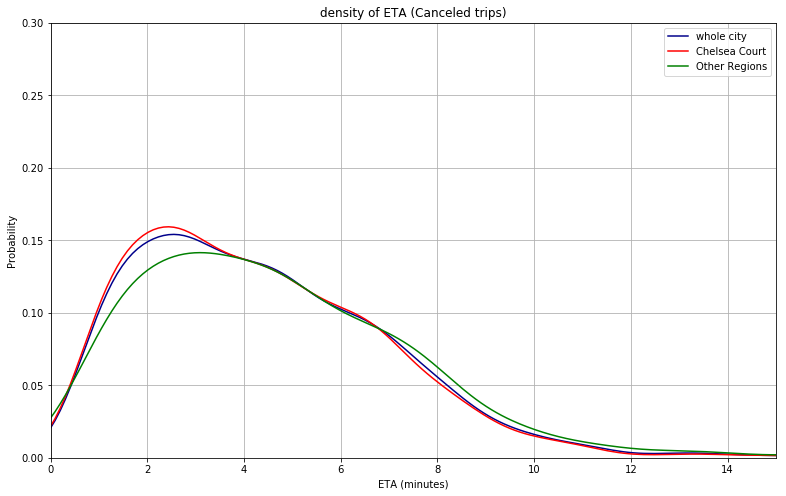

In [334]:
'''distribution of ETA for canceled trips'''

trips_canceled = rider_trips_filtered[rider_trips_filtered.trip_status == "rider_canceled"]
trips_canceled.set_index('trip_status', inplace = True)
trips_canceled.reset_index(inplace=True)

# basic statistics for "estimated time to arrival" for canceled trips
print('\n basic statistics of"ETA" for the whole city\'s canceled trips: \n')
print(trips_canceled['estimated_time_to_arrival'].describe().reset_index())

# basic statistics for "estimated time to arrival" by regions
print('\n basic statistics of"ETA" by starting regions "start_geo" for canceled trips: \n')
print(trips_canceled.groupby('start_geo').estimated_time_to_arrival.agg(['count','mean', 'std','min','max']).reset_index())

# density plot of ETA for trips
ax = plt.figure()
ax = trips_canceled.estimated_time_to_arrival.plot(kind='kde', color ='darkblue', label = 'whole city')
ax = trips_canceled[trips_canceled.start_geo == 'Chelsea Court'].estimated_time_to_arrival.plot(kind = 'kde', color = 'red', label='Chelsea Court')
ax = trips_canceled[trips_canceled.start_geo != 'Chelsea Court'].estimated_time_to_arrival.plot(kind = 'kde', color = 'green', label='Other Regions')
lines, labels = ax.get_legend_handles_labels()
ax.set_xlim(0,15)
ax.set_ylim(0,0.3)
ax.legend(lines, labels, loc=1)
plt.title('density of ETA (Canceled trips)')
plt.xlabel('ETA (minutes)')
plt.ylabel('Probability')
plt.grid()
plt.savefig('fig/density_ETA_canceled_CC_city.png')
plt.savefig('fig/density_ETA_canceled_CC_city.eps')
plt.show()


C:\Users\iris\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


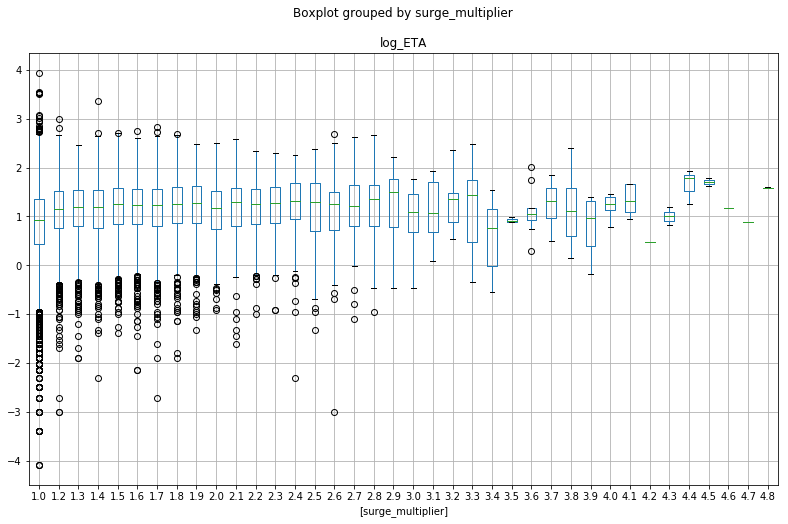

C:\Users\iris\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\iris\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


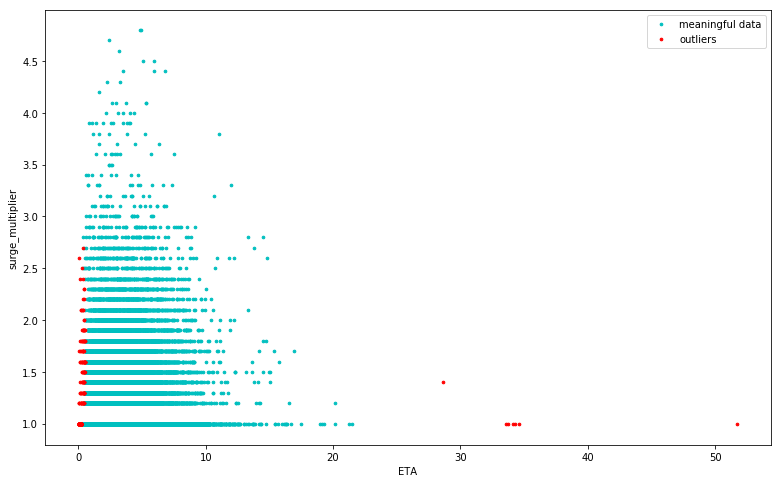

In [335]:
'''exclude outliner of ETA at different surge multiplier level
method: IQR
'''

#box plot
#ax = plt.figure()
#ax = trips_completed.boxplot(column=['estimated_time_to_arrival'], by=['surge_multiplier'])
#plt.show()

#rescale the data by log
trips_completed['log_ETA'] = np.log(trips_completed.estimated_time_to_arrival)


ax = plt.figure()
ax = trips_completed.boxplot(column=['log_ETA'], by=['surge_multiplier'])
plt.savefig('fig/outlier_boxplot.png')
plt.savefig('fig/outlier_boxplot.eps')
plt.show()

#determine min and max
sp_levels = np.sort(trips_completed.surge_multiplier.unique()).tolist()
min_IQR = np.zeros(len(sp_levels))
max_IQR = np.zeros(len(sp_levels))

trips_completed['outlier'] = 0
per_high = 80
per_low = 20

for sp, df in trips_completed.groupby('surge_multiplier'):
    idx = sp_levels.index(sp)       
    q_high, q_low = np.percentile(np.array(df.log_ETA), [per_high,per_low])
    iqr = q_high - q_low
    min_IQR[idx] = np.exp(q_low - iqr * 1.5)
    max_IQR[idx] = np.exp(q_high + iqr * 1.5)
    trips_completed.loc[(trips_completed.surge_multiplier == sp) & (trips_completed.estimated_time_to_arrival < min_IQR[idx]), 'outlier'] = 1
    trips_completed.loc[(trips_completed.surge_multiplier == sp) & (trips_completed.estimated_time_to_arrival > max_IQR[idx]), 'outlier'] = 1
    
        
outliers_threshold = pd.DataFrame({'surge_multiplier': sp_levels, 'min_IQR': min_IQR, 'max_IQR':max_IQR}).set_index('surge_multiplier')

#scatter plot
plt.figure()
df_outliers = trips_completed[trips_completed.outlier == 1]
df_meaningful = trips_completed[trips_completed.outlier == 0]

plt.scatter(x = df_meaningful.estimated_time_to_arrival,
            y = df_meaningful.surge_multiplier,
            s = 7, color = 'c', edgecolor = 'c', alpha = 1,label='meaningful data')

plt.scatter(x = df_outliers.estimated_time_to_arrival,
            y = df_outliers.surge_multiplier,
            s = 7, color = 'r', edgecolor = 'r', alpha = 1,label='outliers')

plt.ylabel('surge_multiplier')
plt.xlabel('ETA')
#plt.xscale('log')
lines, labels = plt.gca().get_legend_handles_labels()
plt.legend(lines,labels, loc='best')
plt.savefig('fig/outlier_IQR.png')
plt.savefig('fig/outlier_IQR.eps')
plt.show()


In [291]:
'''data with completed trips filtered after outliers'''
trips_completed_filtered = trips_completed[trips_completed.outlier ==0]

# basic statistics
print('\n basic statistics of "ETA" by starting regions "start_geo" for completed trips (without outliers): \n')
print(trips_completed_filtered.groupby('start_geo').estimated_time_to_arrival.agg(['count','mean','std','min','max']).reset_index())


 basic statistics of "ETA" by starting regions "start_geo" for completed trips (without outliers): 

       start_geo  count      mean       std   min        max
0     Allen Abby   9238  3.160345  1.981202  0.25  16.950000
1     Blair Bend   3664  4.243086  2.347997  0.25  21.516667
2  Chelsea Court  34636  3.021726  1.835925  0.25  20.183333
3    Daisy Drive   4099  3.182146  1.925202  0.25  21.283333


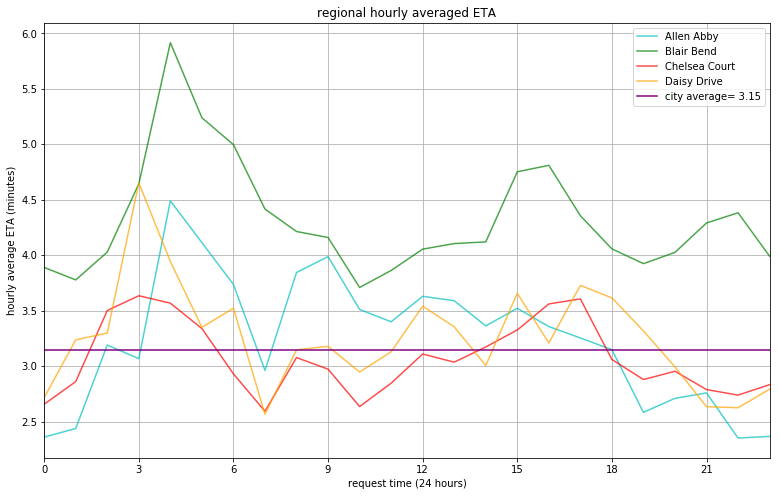

In [292]:
'''hourly evolution of the average of ETA'''

color_regions ={'Allen Abby':'c',
                'Blair Bend':'g',
                'Chelsea Court':'r',
                'Daisy Drive':'orange'}

plt.figure()
for name, region in trips_completed_filtered.groupby('start_geo'):
    df = region.groupby('hour').estimated_time_to_arrival.agg(np.mean).reset_index()
    plt.plot(df.hour, df.estimated_time_to_arrival, alpha = 0.7, color= color_regions[name], label = name)

city_ETA_average_hourly = trips_completed_filtered.estimated_time_to_arrival.mean()
plt.axhline(y=city_ETA_average_hourly, color='purple', linestyle='-',label = 'city average= {:.2f}'.format(city_ETA_average_hourly))

plt.xlabel('request time (24 hours)')
plt.xticks(np.array(range(0,24,3)),list(map(str,range(0,24,3))) )
plt.xlim(0,23)
plt.ylabel('hourly average ETA (minutes)')
plt.title('regional hourly averaged ETA')

plt.grid()
lines, labels = plt.gca().get_legend_handles_labels()
plt.legend(lines, labels, loc='best')
plt.savefig('fig/average_ETA_hourly.png')
plt.savefig('fig/average_ETA_hourly.eps')
plt.show()


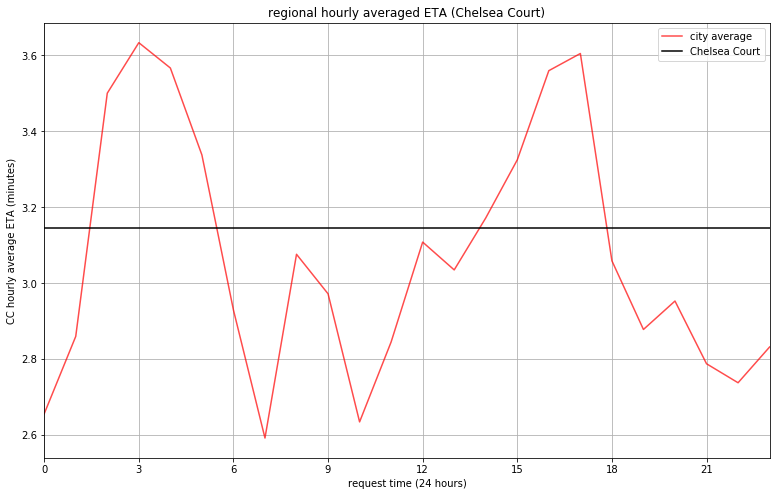

In [293]:
'''Chelsea Court: evulution of ETA'''
df = trips_completed_filtered[trips_completed_filtered.start_geo =='Chelsea Court'].groupby('hour').estimated_time_to_arrival.agg(np.mean).reset_index()
city_ETA_average_hourly = trips_completed_filtered.estimated_time_to_arrival.mean()

plt.figure()
plt.plot(df.hour, df.estimated_time_to_arrival, alpha = 0.7, color= 'r', label = 'Chelsea Court')
plt.axhline(y=city_ETA_average_hourly, color='k', linestyle='-',label = 'city average= {:.2f}'.format(city_ETA_average_hourly))

plt.xlabel('request time (24 hours)')
plt.xticks(np.array(range(0,24,3)),list(map(str,range(0,24,3))) )
plt.xlim(0,23)
plt.ylabel('CC hourly average ETA (minutes)')
plt.title('regional hourly averaged ETA (Chelsea Court)')
plt.legend(labels = [u'city average', u'Chelsea Court'],loc='best')
plt.grid()
plt.savefig('fig/average_ETA_hourly_CC.png')
plt.savefig('fig/average_ETA_hourly_CC.eps')
plt.show()


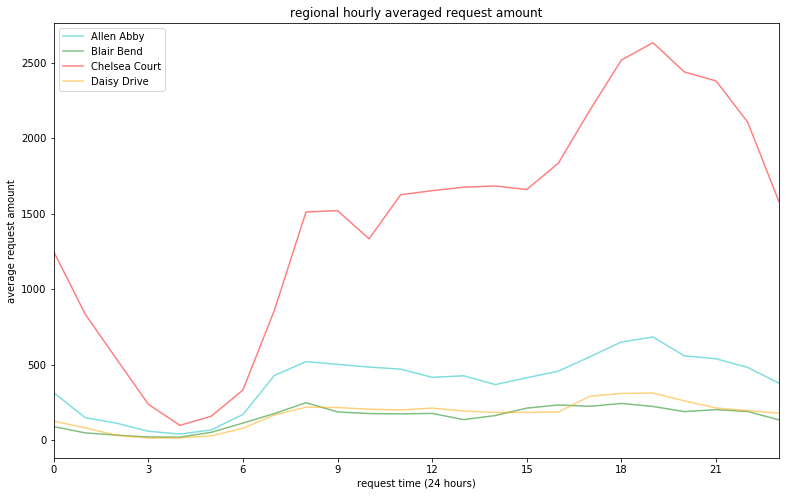

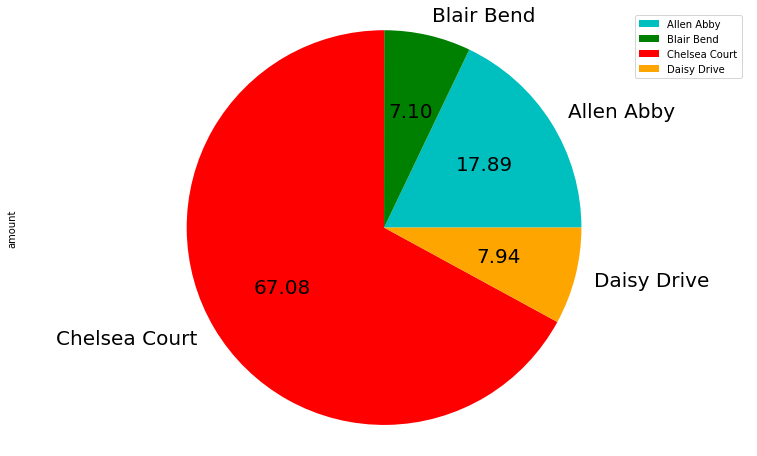

In [294]:
'''number of rider by regions'''

rider_numbers = dict()

plt.figure()
for name, region in trips_completed_filtered.groupby('start_geo'):
    df = region.groupby('hour').size().reset_index().rename(columns= {0:'rider_nb'})
    plt.plot(df.hour, df['rider_nb'],alpha = 0.5, label = name, color=color_regions[name])
    rider_numbers[name] = region.shape[0]
    
plt.xlabel('request time (24 hours)')
plt.xticks(np.array(range(0,24,3)),list(map(str,range(0,24,3))) )
plt.xlim(0,23)
plt.ylabel('average request amount')
plt.title('regional hourly averaged request amount')
lines, labels = plt.gca().get_legend_handles_labels()
plt.legend(lines, labels, loc='best')
plt.savefig('fig/request_amount_hourly.png')
plt.savefig('fig/request_amount_hourly.eps')
plt.show()

#pie plot of total request amount by regions
rider_numbers = pd.DataFrame({'regions':list(rider_numbers.keys()), 'amount':list(rider_numbers.values())})
ax = plt.figure()
ax = rider_numbers.amount.plot.pie(labels=rider_numbers.regions, colors= list(color_regions.values()), autopct='%.2f', fontsize=20)
ax.axis('equal')
ax.legend(loc='best')
plt.savefig('fig/request_amount_regional.png')
plt.savefig('fig/request_amount_regional.eps')
plt.show()


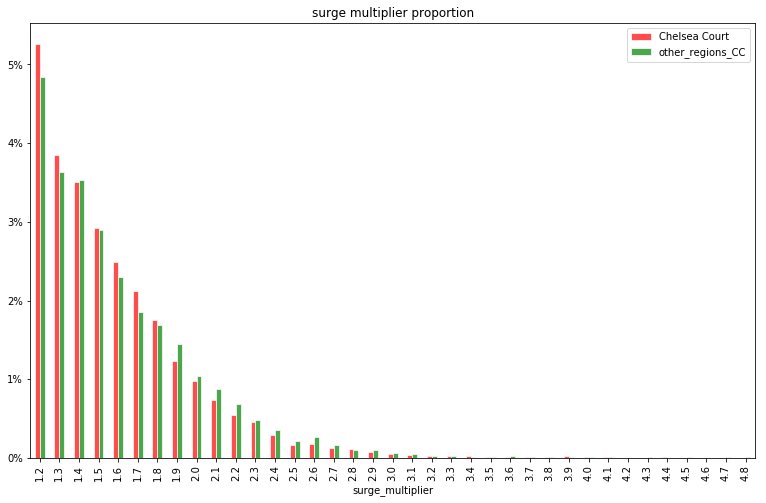

In [295]:
'''proportion of surge multipliers'''

proportion = pd.DataFrame()
for key,value in trips_completed_filtered.groupby('start_geo'):
    proportion = pd.concat([proportion 
                            ,value.groupby('surge_multiplier').size().reset_index().set_index('surge_multiplier').rename(columns={0:key})]
                            ,axis=1, join = 'outer')

proportion = pd.concat([proportion, trips_completed_filtered.groupby('surge_multiplier').size().reset_index().set_index('surge_multiplier').rename(columns={0:'city'})]
                        , axis = 1, join='outer')
    
proportion.fillna(0, inplace=True)
proportion['other_regions_CC'] = proportion['Allen Abby']+proportion['Blair Bend']+proportion['Daisy Drive']

percentage = proportion / proportion.sum()


ax = plt.figure()
ax = percentage.loc[1.1:,['Chelsea Court','other_regions_CC']].plot(kind='bar', alpha =0.7, color = ['r','g'],edgecolor ='w')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
ax.set_title('surge multiplier proportion')
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in vals])
plt.savefig('fig/proportion_sp_CC.png')
plt.savefig('fig/proportion_sp_CC.eps')
plt.show()


In [330]:
'''charts for the reports'''

# basic statistics for "estimated time to arrival"
print('\n basic statistics of "ETA" by "trip status" (all trips): \n')
print(rider_trips.groupby('trip_status').estimated_time_to_arrival.agg(['count','mean', 'std','min','max']).reset_index())
print('\n the number of unfulfilled trips, i.e. ETA = NAN: {:d}'.format(rider_trips[np.isnan(rider_trips.estimated_time_to_arrival)].shape[0]))
print('\n')
      
# basic statistics for "estimated time to arrival" by regions
print('\n basic statistics of "ETA" by starting regions "start_geo" for completed trips (included outliers): \n')
print(trips_completed.groupby('start_geo').estimated_time_to_arrival.agg(['count','mean', 'std','min','max']).reset_index())
print('\n')

#  average ETA for completed trips(without outliers)
print('\n basic statistics of "ETA" by starting regions "start_geo" for completed trips (without outliers): \n')
print(trips_completed_filtered.groupby('start_geo').estimated_time_to_arrival.agg(['count','mean','std','min','max']).reset_index())
print('\n')

# amount of trip by month
print('\n the number of trips request per month (including completed, failed, rider_canceled trips)\n ')
trip_amount = rider_trips.groupby(['month','trip_status']).size().reset_index().rename(columns={0:'amount'})
df = pd.DataFrame({'month': trip_amount.month.unique(),                   
                   'total': np.array(trip_amount.groupby('month').amount.agg(np.sum)),
                   'completed': np.array(trip_amount[trip_amount.trip_status =='completed'].amount),
                   'failed': np.array(trip_amount[trip_amount.trip_status == 'failed'].amount),
                   'rider_canceled': np.array(trip_amount[trip_amount.trip_status == 'rider_canceled'].amount),
                   'unfulfilled': np.array(trip_amount[trip_amount.trip_status == 'unfulfilled'].amount)
                   },
                   columns=['month', 'total', 'completed','failed','rider_canceled','unfulfilled'])
print(df)



 basic statistics of "ETA" by "trip status" (all trips): 

      trip_status  count      mean       std       min        max
0       completed  51929  3.134331  1.979836  0.016667  51.716667
1          failed     20  5.261667  2.387198  1.683333   9.683333
2  rider_canceled   5550  4.541195  3.056405  0.066667  53.416667
3     unfulfilled      0       NaN       NaN       NaN        NaN

 the number of unfulfilled trips, i.e. ETA = NAN: 2501



 basic statistics of "ETA" by starting regions "start_geo" for completed trips (included outliers): 

       start_geo  count      mean       std       min        max
0     Allen Abby   9306  3.138932  1.989695  0.016667  16.950000
1     Blair Bend   3676  4.243925  2.481363  0.033333  51.716667
2  Chelsea Court  34829  3.010993  1.877033  0.016667  34.616667
3    Daisy Drive   4118  3.176595  1.990311  0.033333  34.150000



 basic statistics of "ETA" by starting regions "start_geo" for completed trips (without outliers): 

       start_geo  co